In [ ]:
# !pip3 install googletrans
# !pip3 install spacy
# !pip3 install nltk

In [1]:
import pandas as pd
import geopandas as gpd
import psycopg2
import pandas.io.sql as sqlio
import seaborn as sns
import numpy as np
import string
import re
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import googletrans
from googletrans import Translator
import spacy
from spacy import displacy
from collections import Counter
from IPython.display import Markdown, display

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

2021-11-17 11:45:59.504599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 11:45:59.504637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def hist(data, bins, title, range = None):
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes()
    plt.ylabel("Proportion")
    values, base, _ = plt.hist( data  , bins = bins, density=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
    ax_bis = ax.twinx()
    values = np.append(values,0)
    ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
    plt.ylabel("Proportion")
    plt.title(title)
    plt.show()
    return

In [3]:
def find_sentences_with_keyword(keyword, document):
    
    for sentence in document.sents:
        sentence = sentence.text
        if keyword.lower() in sentence.lower():
            sentence = re.sub('\n', ' ', sentence)
            sentence = re.sub(f"{keyword}", f"**{keyword}**", sentence, flags=re.IGNORECASE)
            
            display(Markdown(sentence))

In [4]:
conn = psycopg2.connect("""
    host=rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net
    port=6432
    dbname=olist
    user=user1
    password=olistolist
    target_session_attrs=read-write
    sslmode=verify-full
""") 
cur = conn.cursor()

### Распределение отзывов

#### Пользователи

In [5]:
df=sqlio.read_sql_query('''SELECT customer_id
            ,count(distinct review_id) as reviews_cnt
            ,count(distinct order_id) as orders_cnt
            ,round(avg(review_score)) as review_score
    FROM public.orders
    left join public.order_reviews using(order_id)
    group by customer_id
    having count(distinct review_id)>1
    order by reviews_cnt desc
;''', conn)


Больше половины пользователей ставит в среднем оценку выше 4, примерно четверть юзеров ставит 3 и ниже

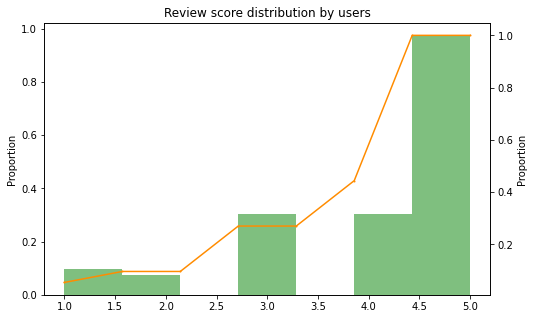

In [6]:
hist(df.review_score, 7, 'Review score distribution by users')

Самые высокие оценки ставят в штатах Амапа и Амазонас, а самые низкие - в Алагоас и Рорайма

In [7]:
sqlio.read_sql_query('''SELECT customer_state, avg(review_score) as review_score
FROM public.orders left join public.customers using(customer_id) 
left join public.order_reviews using(order_id)
group by customer_state
order by review_score desc;''', conn)

,customer_state,review_score
0,AP,4.194030
1,AM,4.183673
2,PR,4.180032
3,SP,4.173951
4,MG,4.136172
5,RS,4.133321
6,MS,4.118785
7,RN,4.105809
8,MT,4.102990
9,TO,4.096774


Все пользователи сделали по одному заказу. 4 пользователя оставило по 3 оценки на один заказ, еще >500 по 2 оценки

In [8]:
df.head()

,customer_id,reviews_cnt,orders_cnt,review_score
0,2a35ad9f439dfc62d35a0202e71d6c66,3,1,3.0
1,b7770073b02ed1d626a027ce86a4ff82,3,1,5.0
2,ae0fb7b01c548c4fd30f19f55453ec4a,3,1,4.0
3,9e29cde4ddb42f9330bcf3c9bc23d177,3,1,1.0
4,0303e5527d4342ac7939d2bfc0f9f9e2,2,1,5.0


Интересно, что на один заказ оставляют по несколько отзывов с разной оценкой. Например, order_id=03c939fd7fd3b38f8485a0f95798f1f6 с тремя разными оценками с разницей в несколько дней 

In [9]:
df=sqlio.read_sql_query('''SELECT * FROM public.orders left join public.order_reviews using(order_id)
where customer_id='2a35ad9f439dfc62d35a0202e71d6c66'
;''', conn)
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02,b04ed893318da5b863e878cd3d0511df,3,None,Um ponto negativo que achei foi a cobrança de ...,2018-03-20,2018-03-21 02:28:23
1,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,4,None,None,2018-03-29,2018-03-30 00:29:09
2,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02,405eb2ea45e1dbe2662541ae5b47e2aa,3,None,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06,2018-03-06 19:50:32


In [10]:
sqlio.read_sql_query('''SELECT * FROM public.order_items where order_id='03c939fd7fd3b38f8485a0f95798f1f6';''', conn)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,03c939fd7fd3b38f8485a0f95798f1f6,1,ab5da1daa941470d14366f4e76a99dd2,d91fb3b7d041e83b64a00a3edfb37e4f,2018-03-02 09:35:46,26.0,16.11


Отзывы связаны с доставкой товаров из заказа по-отдельности. Странно, что в заказе при этом указан один товар

In [11]:
translator = Translator()
translator.translate(df[df.order_id=='03c939fd7fd3b38f8485a0f95798f1f6'].review_comment_message[0], src='pt', dest='ru').text

'Негативным моментом, который я обнаружил, было взимание 3 сборов за доставку, поскольку я купил 3 идентичных продукта за одну покупку.\r\nИ даже покупая продукты вместе, они приехали по отдельности.'

In [12]:
translator.translate(df[df.order_id=='03c939fd7fd3b38f8485a0f95798f1f6'].review_comment_message[2], src='pt', dest='ru').text

'Было бы здорово, если бы они доставили сразу все 3 (три) заказа.'

#### Продавцы

In [13]:
df=sqlio.read_sql_query('''with a as (SELECT seller_id,order_id,review_score
FROM public.order_items 
left join public.order_reviews using(order_id)
left join public.sellers using(seller_id)
where review_score is not null group by seller_id,order_id,review_score)
select seller_id,avg(review_score) as review_score,count(distinct order_id) as orders from a group by seller_id;''', conn)

Более 65% магазинов имеют оценку заказов от 4 и выше. У 16% средняя оценка равна 5, у 14% - оценка 3 и ниже

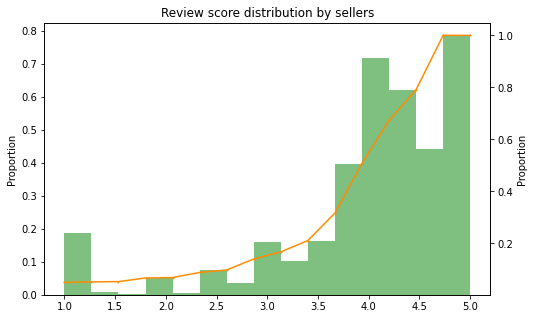

In [14]:
hist(df.review_score, 15, 'Review score distribution by sellers')

In [15]:
len(df[df.review_score<=3])/len(df)

0.13592233009708737

In [16]:
df=sqlio.read_sql_query('''with a as (SELECT seller_id,order_id,count(*) as items
FROM public.order_items left join public.sellers using(seller_id) group by seller_id,order_id)
select seller_id,count(distinct order_id) as orders,sum(items) as items from a group by seller_id;''', conn)

Самый популярный магазин seller_id=6560211a19b47992c3666cc44a7e94c0. В нем было продано более 2k товаров

In [17]:
df.sort_values('orders',ascending=False)[:3]

,seller_id,orders,items
1235,6560211a19b47992c3666cc44a7e94c0,1854,2033.0
881,4a3ca9315b744ce9f8e9374361493884,1806,1987.0
2481,cc419e0650a3c5ba77189a1882b7556a,1706,1775.0


7% магазинов делает 60% всех заказов (более 100 заказов на магазин)

In [18]:
len(df[df.orders>100])/len(df), df[df.orders>100].orders.sum()/df.orders.sum()

(0.06785137318255251, 0.5996300369963004)

У 3/4 магазинов было менее 20 заказов

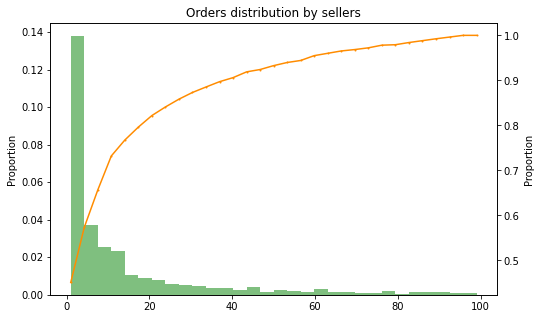

In [19]:
hist(df[df.orders<100].orders, 30, 'Orders distribution by sellers')

In [20]:
len(df[df.orders<=20])/len(df)

0.7421647819063005

#### Товары

In [21]:
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

In [22]:
df=sqlio.read_sql_query('''with a as (SELECT
       distinct order_id, product_category_name, review_score
    FROM public.order_items
    left join public.products using(product_id)
    left join public.order_reviews using(order_id)
   )
   select 
   product_category_name, avg(review_score) as review_score, count(distinct order_id) as orders
   from a
   group by product_category_name
;''', conn).merge(product_category_name_translation,on='product_category_name')

Самые высокие оценки у музыкальных товаров и детской одежды, самые низкие - у офисной мебели и услуг безопасности

In [23]:
df[['product_category_name_english','review_score']].sort_values('review_score').tail(2)

,product_category_name_english,review_score
37,fashion_childrens_clothes,4.500000
17,cds_dvds_musicals,4.666667


In [24]:
df[['product_category_name_english','review_score']].sort_values('review_score').head(2)

,product_category_name_english,review_score
65,security_and_services,2.500000
55,office_furniture,3.615324


Чаще всего заказывают товары для дома и красоты/здоровья

In [25]:
df[['product_category_name_english','orders']].sort_values('orders').tail(2)

,product_category_name_english,orders
11,health_beauty,8836
13,bed_bath_table,9417


В абсолютном большинстве заказов (90%) содержится 1 товар. Более 2 товаров всего в 2% заказов

In [26]:
df=sqlio.read_sql_query('''SELECT order_id, count(*) as items FROM public.order_items group by order_id;''', conn)
len(df[df['items']==1])/len(df),len(df[df['items']>2])/len(df)

(0.9006445989499929, 0.023179210670342367)

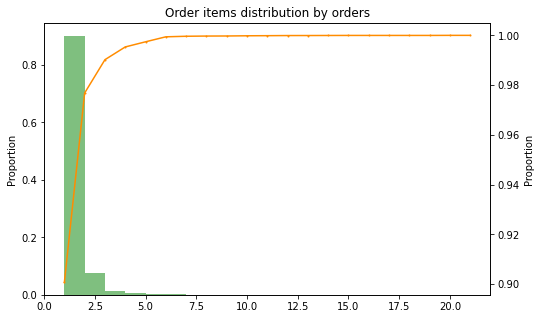

In [27]:
hist(df['items'], 20, 'Order items distribution by orders')

In [75]:
df=sqlio.read_sql_query('''with a as (SELECT distinct order_id, product_id, review_score FROM public.order_items 
left join public.order_reviews using(order_id)
where review_score is not null)
select product_id, avg(review_score) as review_score from a group by product_id
;''', conn)

У 20% товаров оценка 3 и ниже. Почти у половины товаров оценка 5

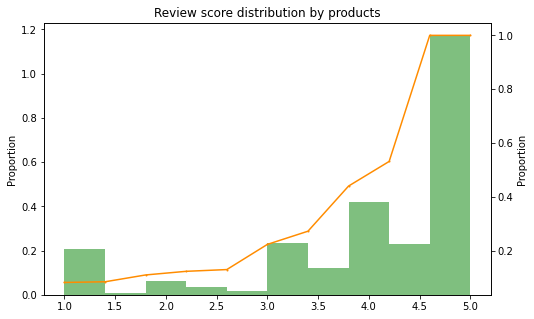

In [29]:
hist(df.review_score, 10, 'Review score distribution by products')

In [30]:
products = sqlio.read_sql_query("SELECT * FROM public.products;", conn)

In [31]:
df=df.merge(products,on='product_id').sort_values('review_score').merge(product_category_name_translation,on='product_category_name',how='left')

In [32]:
df['review_score_round']=round(df['review_score'])

Товары с более подробным описанием и с более высоким качеством фото получают в среднем выше оценку

In [33]:
df[df.review_score_round>1].groupby(['review_score_round'])[['product_description_lenght','product_photos_qty']].agg([np.mean]).T

,review_score_round,2.0,3.0,4.0,5.0
product_description_lenght,mean,705.813740,738.111988,777.052291,785.141486
product_photos_qty,mean,2.076336,2.115933,2.252003,2.190993


#### Сроки доставки

In [79]:
df=sqlio.read_sql_query('''SELECT * FROM public.orders join public.order_reviews using(order_id);''', conn)

In [80]:
df['delivery_time']=df['order_delivered_customer_date']-df['order_approved_at']
df['delivery_time']=df['delivery_time'].apply(lambda x: x.total_seconds()/(60*60*24))

In [81]:
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,delivery_time
0,e48aa0d2dcec3a2e87348811bcfdf22b,840be0730010e9580efd289bc9f37706,delivered,2017-06-30 15:38:46,2017-06-30 15:50:17,2017-07-03 16:22:53,2017-07-15 12:57:24,2017-08-03,07f9bee5d1b850860defd761afa7ff16,5,None,None,2017-07-16,2017-07-18 19:30:34,14.879942
1,c31a859e34e3adac22f376954e19b39d,98f485515e575607a8003b17e91990bd,delivered,2018-08-07 23:12:29,2018-08-07 23:25:10,2018-08-08 14:18:00,2018-08-13 18:08:28,2018-10-10,7c6400515c67679fbee952a7525281ef,5,None,None,2018-08-14,2018-08-14 21:36:06,5.780069


Чем меньше среднее время доставки, тем выше оценка

In [82]:
df.groupby(['review_score'])[['delivery_time']].agg([np.mean]).T

,review_score,1,2,3,4,5
delivery_time,mean,20.856306,16.204752,13.808944,11.881622,10.269995


#### Объемы продаж

Большинство заказов имеет оценку 5

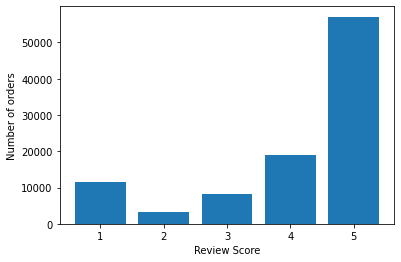

In [38]:
df=sqlio.read_sql_query('''SELECT distinct order_id,review_score FROM public.order_reviews;''', conn)
review_score=df.groupby('review_score').count()
plt.bar(review_score.index.values, review_score['order_id'])
plt.xlabel('Review Score')
plt.ylabel('Number of orders')
plt.show()

In [39]:
df=sqlio.read_sql_query('''select product_id, avg(review_score) as review_score, sum(sold) as sold 
from (SELECT order_id, product_id, review_score, count(*) as sold FROM public.order_items 
left join public.order_reviews using(order_id)
group by order_id, product_id, review_score) as t
group by product_id
;''', conn)

При этом наибольшие объемы продаж у товаров со средней оценкой 4

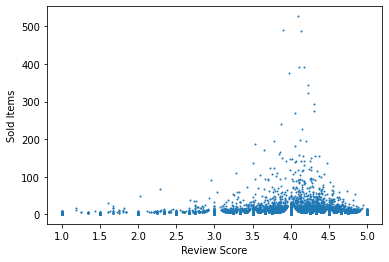

In [40]:
plt.scatter(df.review_score,df.sold,s=1)
plt.xlabel('Review Score')
plt.ylabel('Sold Items')
plt.show()

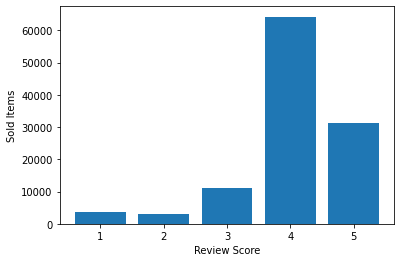

In [41]:
df['review_score_r']=round(df['review_score'])
review_score=df.groupby('review_score_r').sum()
plt.bar(review_score.index.values, review_score['sold'])
plt.xlabel('Review Score')
plt.ylabel('Sold Items')
plt.show()

#### О чем пишут в отзывах

In [42]:
df=sqlio.read_sql_query('''SELECT * FROM public.order_reviews;''', conn).dropna(subset=['review_comment_message']).reset_index()

In [43]:
# объединяем отзывы в единый текст. Удаляем цифры из текста
text=df['review_comment_message'].str.cat(sep=' ')
text = re.sub(r'[0-9]+', '', text)

In [44]:
# разбиваем текст на слова и находим самые часто встречающиеся. Видим, что есть много шума
tokenized_word=word_tokenize(text)
fdist = FreqDist(tokenized_word)
fdist

FreqDist({'.': 29194, ',': 22471, 'e': 14919, 'o': 14890, 'produto': 13838, 'de': 10854, 'do': 10820, '!': 10550, 'a': 10394, 'não': 8419, ...})

In [45]:
# чистим от шума и пунктуации, используем библиотеку nltk

stop_words=set(stopwords.words("portuguese"))

filtered=[]
for w in tokenized_word:
    if w not in stop_words and w not in list(string.punctuation):
        filtered.append(w)

In [46]:
# сократили текст почти в два раза
len(filtered),len(tokenized_word)

(313587, 541614)

In [47]:
# приведем однокоренные слова к исходному слову
ps = nltk.stem.RSLPStemmer()
stemmed_words = []
for w in filtered: 
    stemmed_words.append(ps.stem(w))

In [48]:
# видим, что сократили число уникальных слов вдвое
len(set(filtered)),len(set(stemmed_words))
# ,len(set(lemmatized_words))

(20882, 9500)

In [49]:
# для дальнейшем обработки используем португальскую языковую модель pt_core_news_md
nlp = spacy.load('pt_core_news_md')

In [50]:
# преобразуем очищенный массив слов в формат модели (делим массив пополам, т.к ограничение 1 млн знаков)
n=round(len(stemmed_words)/2)
document1 = nlp(" ".join(stemmed_words[:n]))
document2 = nlp(" ".join(stemmed_words[n:]))

In [51]:
 # приведем словоформы к их словарной форме (лемме)
lemmed_words=[]
for token in document1: lemmed_words.append(token.lemma_)
for token in document2: lemmed_words.append(token.lemma_)

In [52]:
len(set(stemmed_words)),len(set(lemmed_words))

(9500, 9168)

In [53]:
# считаем частоту слов
fdist = FreqDist(lemmed_words)
fdist

FreqDist({'produt': 19622, 'entreg': 11898, 'prazer': 8471, 'compr': 7311, 'o': 6869, 'cheg': 6480, 'receb': 6461, 'bom': 6048, 'ant': 5645, 'recom': 4272, ...})

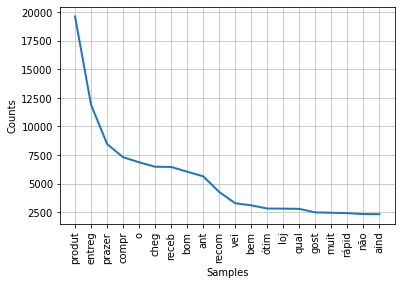

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [54]:
fdist.plot(20)

In [55]:
df = pd.DataFrame.from_dict(dict(fdist),orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'fdist'})

In [56]:
# переведем на русский самые частые слова
translator = Translator()
ru=[]
fr_df=df[:20]

for word in range(len(fr_df)):
    ru.append(translator.translate(fr_df['word'][word], src='pt', dest='ru').text)
    
fr_df['ru']=ru

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<function matplotlib.pyplot.show(close=None, block=None)>

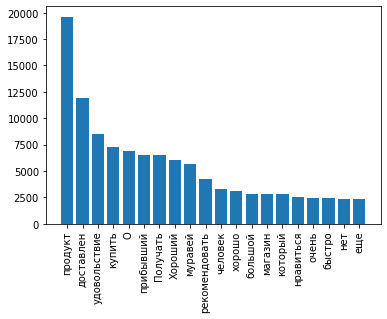

In [57]:
plt.bar(fr_df.ru,fr_df.fdist)
plt.xticks(rotation=90)
plt.show

Видно, что остались предлоги и междометия. Посмотрим на самые частые прилагательные, существительные, глаголы

In [58]:
# самые частые прилагательные

adjs = []
for token in document1:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
for token in document2:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        
adjs_tally = Counter(adjs)

adj_df=pd.DataFrame.from_dict(dict(adjs_tally.most_common(20)),orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'fdist'})

# переведем на русский
translator = Translator()
ru=[]

for word in range(len(adj_df)):
    ru.append(translator.translate(adj_df['word'][word], src='pt', dest='ru').text)
    
adj_df['ru']=ru

Самые частые прилагательные имеют позитивную окраску (хороший, правильно, идеально, лучший, красивый, быстро)

<function matplotlib.pyplot.show(close=None, block=None)>

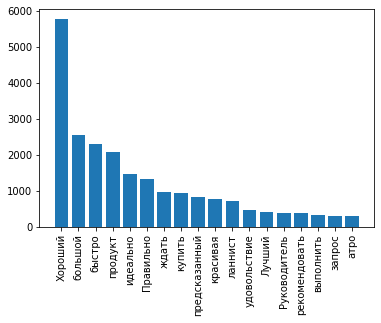

In [59]:
data=adj_df[:20]
plt.bar(data.ru,data.fdist)
plt.xticks(rotation=90)
plt.show

In [60]:
verbs = []
for token in document1:
    if token.pos_ == 'VERB':
        verbs.append(token.lemma_)
for token in document2:
    if token.pos_ == 'VERB':
        verbs.append(token.lemma_)
        
verbs_tally = Counter(verbs)

verbs_df=pd.DataFrame.from_dict(dict(verbs_tally.most_common(20)),orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'fdist'})

translator = Translator()
ru=[]

for word in range(len(verbs_df)):
    ru.append(translator.translate(verbs_df['word'][word], src='pt', dest='ru').text)
    
verbs_df['ru']=ru

In [61]:
verbs_df.head()

,word,fdist,ru
0,entreg,11886,доставлен
1,receb,6461,Получать
2,cheg,6316,прибывший
3,gost,2318,нравиться
4,produt,1493,продукт


<function matplotlib.pyplot.show(close=None, block=None)>

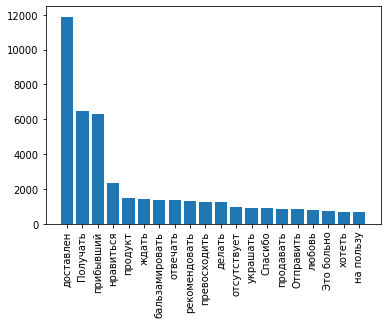

In [62]:
# самые частые глаголы
data=verbs_df
plt.bar(data.ru,data.fdist)
plt.xticks(rotation=90)
plt.show

Глаголы касаются преимуществнно доставки (доставлен, получать, ждать, отправить) и отношения к товару (нравиться, рекомендовать, превосходить)

In [63]:
# translator.translate(nouns_df['word'][0], src='pt', dest='ru').text

In [64]:
nouns = []
for token in document1:
    if token.pos_ == 'NOUN':
        nouns.append(token.lemma_)
for token in document2:
    if token.pos_ == 'NOUN':
        nouns.append(token.lemma_)
        
nouns_tally = Counter(nouns)

# отбираем самые частые существительные
nouns_df=pd.DataFrame.from_dict(dict(nouns_tally.most_common(20)),orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'fdist'})

# переведем на русский
translator = Translator()
ru=[]

for word in range(len(nouns_df)):
    ru.append(translator.translate(nouns_df['word'][word], src='pt', dest='ru').text)
    
nouns_df['ru']=ru

In [65]:
nouns_df.head()

,word,fdist,ru
0,produt,15197,продукт
1,prazer,7915,удовольствие
2,compr,5523,купить
3,ant,4062,муравей
4,dia,2122,день


<function matplotlib.pyplot.show(close=None, block=None)>

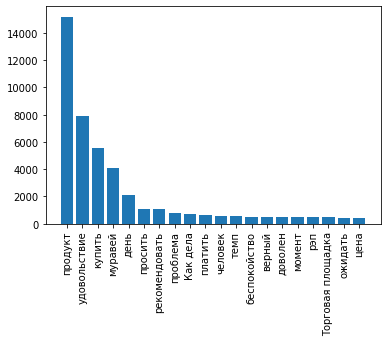

In [66]:
# самые частые существительные
data=nouns_df
plt.bar(data.ru,data.fdist)
plt.xticks(rotation=90)
plt.show

Больше всего пользователй волнует доставка (темп, момент, ожидание), цена, качество товара (доволен, рекомендовать, удовольствие)

Посмотрим, в каком контексте встречаются конкретные слова в отзывах. Например, явно вызывает вопросы слово муравей в топе существительных и бальзамировать в топе глаголов

In [67]:
document = nlp(text[:10000])

In [68]:
find_sentences_with_keyword(keyword="ant", document=document)

Recebi bem **ant**es do prazo estipulado.

  Vendedor confiável, produto ok e entrega **ant**es do prazo.

A entrega foi efetuada muito **ant**es do prazo dado.

Comprei gato por lebre Sempre compro pela Internet e a entrega ocorre **ant**es do prazo combinado, que acredito ser o prazo máximo.

otimo vendedor chegou ate **ant**es do prazo , adorei o produto Processo de compra tranquilo e eficiente.

Faltou Controle Remoto para Ar Condicionado Consul boa MT lindo Ocorreu tudo como contratado sendo a entrega realizada **ant**es do prazo   Estou satisfeita  Amei achei lindo ,muito delicado adorei Ótima loja para parceria:

sempre chega com muiiita **ant**ecedencia..

Produto de muito boa qualidade, chegou **ant**es do prazo prometido Este foi o pedido 

Produto de acordo com o anunciado e a entrega super rápida , entregou bem **ant**es do prazo .

Demorou de mais pra entrega  super rapido a entrega .... chegou **ant**es da data...  

Chegou apenas uma peça, mas na nota e na gar**ant**ia constam as duas joias.

Precisa melhorar nas entregas Espero receber esta semana, o que não seria tão extravag**ant**e, porém...

Contato com a loja muito dificil,t**ant**o via e-mail qto por telef.

No site das lannister costumam chegar **ant**es do prazo.

Entrega **ant**es do prazo.

Cancelaram a minha compra um dia **ant**es da entrega, liguei para a lannister e os atendentes não sabiam o que estava acontecendo, uma bagunça, agora estou esperando para ver se vai ser cobrado produto de qualidade e eficiência na entrega.

recebi muito **ant**es do combinado.

Entrega bem **ant**es do prazo perfeito!!

Creme maravilhoso e entrega super rápida Tentando cancelar o produto desde **ant**es da emissão da nota fiscal.

Chegou hoje  sem comentários Boa Noite  é lamentável, esta loja que t**ant**as compras eu ja fiz e hoje não me da satisfação sequer de um relógio na importância de , reais ... um produto com defeito e até agora não me deu retor Muito bom!

Видимо в ходе приведения к корню предлог antes (до) прератился в муравья. Аналогичная ситуация с embalado/embalagem (упакованный/упаковка), которое превратилось в глагол embal - бальзамировать. Нужна более тщательная обработка слов при подготовке.

Интересно, что слово produt (продукт) попало не только в существительные, но в прилагательные и глаголы

#### Предсказание оценки по отзыву

На основе имеющихся отзывов и оценок заказов можно обучить модель, которая будет предсказывать оценку по отзыву

In [69]:
df=sqlio.read_sql_query('''SELECT * FROM public.order_reviews;''', conn).dropna(subset=['review_comment_message']).reset_index()

In [70]:
stop_words=list(stop_words)+['amos', 'at', 'est', 'estiv', 'f', 'h', 'houv', 'j', 'm', 'n', 'nhamos', 'ramos', 's', 'ser', 'ssemos', 't', 'tamb', 'ter', 'tiv', 'vamos', 'voc']

In [71]:
# уберем из отзывов ненужные символы и шум

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True, stop_words=stop_words, ngram_range = (1,1), tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['review_comment_message'])

In [72]:
# разобъем отзывы на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['review_score'], test_size=0.3, random_state=1)

In [73]:
# используем модель Multinomial Naive Bayes

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

In [74]:
# проверим точность предсказания

print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6655278997885147


Точность модели довольно низкая. Можно улучшать точность за счет более качественной предобработки отзывов и изменения параметров модели